In [1]:
# !pip install --upgrade wandb -q
# !wandb login <API KEY>

In [2]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
import wandb
# %matplotlib inline
# from PIL import Image

## config

In [3]:
ds_dir = '/kaggle/input/sign-language-mnist/'

epochs = 25
lr = 0.001
# momentum = 0.9
train_batch_size = 12000 #27455
test_batch_size = 5000 #7172
wb = False

## dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        csv_dir = os.path.join(root_dir, csv_file)
        csv = pd.read_csv(csv_dir)
        self.labels = csv.iloc[:,0]
        self.images = csv.iloc[:,1:]
        self.images = (self.images.values).reshape(-1,28,28).astype('float32')
        self.labels = torch.tensor(self.labels)
#         self.labels = F.one_hot(self.labels)
        if transform:
            for i in range(self.images.shape[0]):
                self.images[i] = transform(self.images[i])
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
#         if torch.is_tensor(index):
#             index = index.tolist()
        
        img = self.images[index]
        label = self.labels[index]
    
        sample = {'image': img, 'label': label}
        
        return sample

# ds = dataset('sign_mnist_test/sign_mnist_test.csv', ds_dir, transform=None)
# ds[0]['label']

In [5]:
# csv = pd.read_csv(os.path.join(ds_dir, 'sign_mnist_test/sign_mnist_test.csv'))
# # print(csv.loc[csv['label'] == 9].head())
# # img = csv.iloc[21, 1:]
# # img = (img.values).reshape(28,28).astype('float32')
# # plt.imshow(img, 'gray')
# labels = F.one_hot(torch.tensor(csv.iloc[:,0]))
# for i in range (50):
#     print('eeky' if labels[i][9] != 0 else '', end='')

## dataloader

In [6]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomRotation(degrees=5),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

trainset = dataset('sign_mnist_train/sign_mnist_train.csv', ds_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=1)

testset = dataset('sign_mnist_test/sign_mnist_test.csv', ds_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                          shuffle=True, num_workers=1)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'] # no 'J' or 'Z'

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
# import string
# for i in string.ascii_uppercase:
#     print(f'\'{i}\', ', end='')

## sneak peek

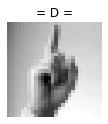

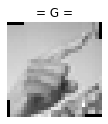

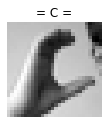

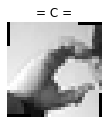

In [8]:
def show_imgs(image, label):
    plt.imshow(torch.squeeze(torch.tensor(image)), 'gray')
    plt.pause(0.001)

fig = plt.figure()

for i in range(len(trainset)):
    sample = trainset[i]
    
#     print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    ax.set_title('= {} ='.format(classes[sample['label']]))
    ax.axis('off')
    plt.tight_layout()
    show_imgs(**sample)
    

    if i == 3:
        plt.show()
        break

## model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.pool = nn.MaxPool2d(2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 25)

    def forward(self, x):
        # correct shape
        x = x.reshape(-1, 1, 28, 28)
        # conv blocks
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch_norm1(x)
        x = self.swish(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        x = self.pool(self.swish(self.conv3(x)))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        # reshape for linear layers
        x = x.view(-1, 128*4*4)
        # linear block
        x = self.swish(self.fc1(x))
        x = self.dropout(x)
        x = self.swish(self.fc2(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        
    def swish(self, x):
        return x * F.sigmoid(x)

# net = Net()
# net(torch.randn(2, 1, 28, 28)).shape

## model summary

In [10]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(Net())

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
|    conv1.weight    |     64     |
|     conv1.bias     |     16     |
| batch_norm1.weight |     16     |
|  batch_norm1.bias  |     16     |
|    conv2.weight    |    9216    |
|     conv2.bias     |     64     |
| batch_norm2.weight |     64     |
|  batch_norm2.bias  |     64     |
|    conv3.weight    |   73728    |
|     conv3.bias     |    128     |
| batch_norm3.weight |    128     |
|  batch_norm3.bias  |    128     |
|     fc1.weight     |  2097152   |
|      fc1.bias      |    1024    |
|     fc2.weight     |   524288   |
|      fc2.bias      |    512     |
| batch_norm4.weight |    512     |
|  batch_norm4.bias  |    512     |
|     fc3.weight     |   131072   |
|      fc3.bias      |    256     |
|     fc4.weight     |    6400    |
|      fc4.bias      |     25     |
+--------------------+------------+
Total Trainable Params: 2845385


2845385

## training

In [11]:
if wb:
    wandb.init(project="sign-lang")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
steps = 0
print_every = 1
running_loss = 0
train_losses, test_losses = [], []


net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(epochs):
    for inputs in trainloader:
        steps += 1
        inputs, labels = (inputs['image']).to(device), (inputs['label']).to(device)
        optimizer.zero_grad()
        out = net(inputs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs in testloader:
                    inputs, labels = (inputs['image']).to(device), (inputs['label']).to(device)
                    out = net(inputs)
                    batch_loss = criterion(out, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(out)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            if wb:
                wandb.log({'Train Loss':running_loss/print_every, 'Test Loss': test_loss/len(testloader), 'Test Accuracy':accuracy/len(testloader)})

            running_loss = 0
            net.train()
dest = f'sign_lang_lr_{lr}_epo_{epochs}_'
v = 0
while os.path.isfile(dest+str(v)):
    v += 1
torch.save(net, dest+str(v)+'.pth')

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/25.. Train loss: 3.254.. Test loss: 3.207.. Test accuracy: 0.040
Epoch 1/25.. Train loss: 2.841.. Test loss: 3.188.. Test accuracy: 0.080
Epoch 1/25.. Train loss: 2.478.. Test loss: 3.147.. Test accuracy: 0.291
Epoch 2/25.. Train loss: 2.158.. Test loss: 3.085.. Test accuracy: 0.352
Epoch 2/25.. Train loss: 1.877.. Test loss: 2.996.. Test accuracy: 0.467
Epoch 2/25.. Train loss: 1.629.. Test loss: 2.875.. Test accuracy: 0.529
Epoch 3/25.. Train loss: 1.412.. Test loss: 2.741.. Test accuracy: 0.547
Epoch 3/25.. Train loss: 1.211.. Test loss: 2.600.. Test accuracy: 0.528
Epoch 3/25.. Train loss: 1.050.. Test loss: 2.415.. Test accuracy: 0.558
Epoch 4/25.. Train loss: 0.894.. Test loss: 2.222.. Test accuracy: 0.542
Epoch 4/25.. Train loss: 0.760.. Test loss: 2.048.. Test accuracy: 0.517
Epoch 4/25.. Train loss: 0.650.. Test loss: 1.813.. Test accuracy: 0.584
Epoch 5/25.. Train loss: 0.552.. Test loss: 1.627.. Test accuracy: 0.615
Epoch 5/25.. Train loss: 0.467.. Test loss: 1.497..

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## model 2

In [12]:
# import torch.nn as nn
# import torch.nn.functional as F

# class XNet(nn.Module):
#     def __init__(self):
#         super(XNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, 2)
#         self.pool = nn.MaxPool2d(2)
#         self.batch_norm1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 64, 3)
#         self.batch_norm2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, 3)
#         self.batch_norm3 = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(2048, 1024)
#         self.dropout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(1024, 512)
#         self.batch_norm4 = nn.BatchNorm1d(512)
#         self.fc3 = nn.Linear(512, 256)
#         self.fc4 = nn.Linear(256, 1)

#     def forward(self, x):
#         # correct shape
#         x = x.reshape(-1, 1, 28, 28)
#         # conv blocks
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.batch_norm1(x)
#         x = self.swish(self.conv2(x))
#         x = self.dropout(x)
#         x = self.batch_norm2(x)
#         x = self.pool(self.swish(self.conv3(x)))
#         x = self.dropout(x)
#         x = self.batch_norm3(x)
#         # reshape for linear layers
#         x = x.view(-1, 128*4*4)
#         # linear block
#         x = self.swish(self.fc1(x))
#         x = self.dropout(x)
#         x = self.swish(self.fc2(x))
#         x = self.dropout(x)
#         x = self.batch_norm4(x)
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x
        
#     def swish(self, x):
#         return x * torch.sigmoid(x)

# # net = XNet()
# # net(torch.randn(2, 1, 28, 28))

## train 2

In [13]:
# if wb:
#     wandb.init(project="sign-lang")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# steps = 0
# print_every = 1
# running_loss = 0
# train_losses, test_losses = [], []


# net = XNet().to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# for epoch in range(epochs):
#     for inputs in trainloader:
#         steps += 1
#         inputs, labels = (inputs['image']).to(device), (inputs['label']).to(device)
#         optimizer.zero_grad()
#         out = net(inputs)
#         loss = criterion(torch.squeeze(out), labels.float())
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             net.eval()
#             with torch.no_grad():
#                 for inputs in testloader:
#                     inputs, labels = (inputs['image']).to(device), (inputs['label']).to(device)
#                     out = net(inputs)
#                     batch_loss = criterion(out, labels)
#                     test_loss += batch_loss.item()
                    
#                     ps = torch.exp(out)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
#             train_losses.append(running_loss/len(trainloader))
#             test_losses.append(test_loss/len(testloader))                    
#             print(f"Epoch {epoch+1}/{epochs}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"Test loss: {test_loss/len(testloader):.3f}.. "
#                   f"Test accuracy: {accuracy/len(testloader):.3f}")
#             if wb:
#                 wandb.log({'Train Loss':running_loss/print_every, 'Test Loss': test_loss/len(testloader), 'Test Accuracy':accuracy/len(testloader)})

#             running_loss = 0
#             net.train()
# dest = f'Xsign_lang_lr_{lr}_epo_{epochs}'
# v = 0
# while os.path.isfile(dest+str(v)):
#     v += 1
# torch.save(net, dest+str(v)+'.pth')